### Forecast de demanda: Facturapp

### ✅ Prophet

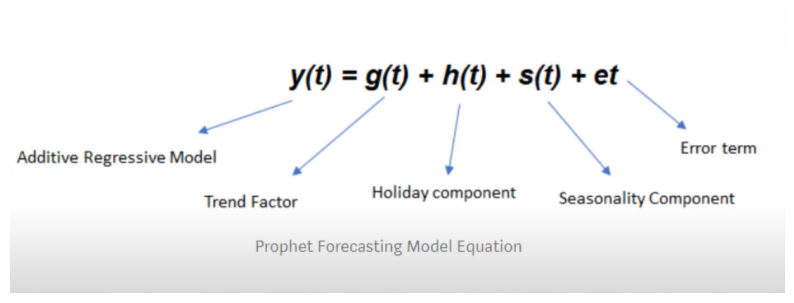

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar la imagen
img = mpimg.imread('C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/04_Prophet/Prophet forecasting model equation.PNG')

# Mostrar la imagen
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Para ocultar los ejes
plt.show()


##### Datos

In [2]:
import warnings
warnings.simplefilter("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [3]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [14]:
# Realizamos el merge de ventas_df con productos_df basado en codigo_producto
ventas_df = ventas_df.merge(productos_df[['codigo_producto', 'descripcion_producto']], 
                            on='codigo_producto', 
                            how='left')

# Verificamos el resultado
ventas_df.head()

,codigo_producto,moneda_venta,id_cliente,fecha_venta,monto_ventas_producto,cantidad_ventas_producto,descripcion_producto
0,0,$,1241,2022-12-30,0.0,1.0,CARTA COLORES TINTA LEAU VIVE
1,0,$,1258,2022-12-16,0.0,1.0,CARTA COLORES TINTA LEAU VIVE
2,0,$,1201,2024-01-30,0.0,1.0,CARTA COLORES TINTA LEAU VIVE
3,0,$,1260,2023-03-01,0.0,1.0,CARTA COLORES TINTA LEAU VIVE
4,0,$,1403,2023-08-15,0.0,1.0,CARTA COLORES TINTA LEAU VIVE


In [7]:
# Crear la tabla agregada
df_prophet = ventas_df.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Renombramos variables para que prophet tome como input
df = df_prophet.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})
df.head()

,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


In [9]:
import plotly.express as px

px.line(df, x='ds', y='y',title="Forecast de demanda Facturapp")

#### Variables exógenas

In [10]:
# Asegúrate de que la columna 'ds' sea de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Variables exógenes: Crear la nueva columna 'end_of_day' y 'end_of_month'
df['end_of_week'] = df['ds'].apply(lambda x: 1 if x.dayofweek == 6 else 0)
df['end_of_month'] = df['ds'].apply(lambda x: 1 if x.is_month_end else 0)

In [11]:
df.head()

,ds,y,end_of_week,end_of_month
0,2022-04-16,39.000,0,0
1,2022-04-17,165.640,1,0
2,2022-04-18,2235.130,0,0
3,2022-04-19,1167.624,0,0
4,2022-04-20,1734.857,0,0


##### Train Model

In [15]:
from prophet import Prophet

m = Prophet(
    growth='linear',  # Define el tipo de tendencia de crecimiento. "linear" (predeterminado) o "logistic".

    changepoints=None,  # Lista de fechas donde se espera que la tendencia cambie. None para detección automática.
    
    n_changepoints=25,  # Número de puntos de cambio a ser detectados automáticamente. El valor predeterminado es 25.
    
    changepoint_range=0.8,  # Proporción del historial en el que se detectan los puntos de cambio. El valor predeterminado es 0.8 (80% del historial).
    
    yearly_seasonality='auto',  # Controla la estacionalidad anual. Puede ser True, False, un entero o 'auto' (predeterminado).
    
    weekly_seasonality='auto',  # Controla la estacionalidad semanal. Puede ser True, False, un entero o 'auto' (predeterminado).
    
    daily_seasonality=True,  # Controla la estacionalidad diaria. Puede ser True, False, un entero o 'auto' (predeterminado).
    
    holidays=None,  # DataFrame con las fechas de los días festivos a incluir en el modelo. None para no incluir días festivos.

    seasonality_mode='additive',  # Define el modo de estacionalidad: 'additive' (predeterminado) o 'multiplicative'.
    
    seasonality_prior_scale=10.0,  # Controla la regularización de la estacionalidad. El valor predeterminado es 10.0.
    
    holidays_prior_scale=10.0,  # Controla la regularización de los efectos de días festivos. El valor predeterminado es 10.0.
    
    changepoint_prior_scale=0.05,  # Controla la regularización de los puntos de cambio en la tendencia. El valor predeterminado es 0.05.
    
    mcmc_samples=0,  # Número de muestras MCMC para la estimación de la incertidumbre. El valor predeterminado es 0 (no se utiliza MCMC).
    
    interval_width=0.95,  # Ancho del intervalo de incertidumbre. El valor predeterminado es 0.80, aquí se configura al 95%.
    
    uncertainty_samples=1000,  # Número de muestras para la estimación de incertidumbre posterior. El valor predeterminado es 1000.
    
    stan_backend=None  # Backend a utilizar para las muestras MCMC. Puede ser 'CMDSTANPY', 'PYRO', o None (utiliza el predeterminado).
)

m.add_country_holidays(country_name='UY')

model = m.fit(df_prophet)

00:53:42 - cmdstanpy - INFO - Chain [1] start processing
00:53:42 - cmdstanpy - INFO - Chain [1] done processing


#### Make Predictions

In [16]:
future = m.make_future_dataframe(periods=60, freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Constitution Day,Constitution Day_lower,Constitution Day_upper,Day of the Family,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-04-16,226.615925,-99.863560,2449.884747,226.615925,226.615925,0.0,0.0,0.0,0.0,...,70.567725,70.567725,70.567725,118.614380,118.614380,118.614380,0.0,0.0,0.0,1167.146114
1,2022-04-17,229.909792,-1936.826007,675.064332,229.909792,229.909792,0.0,0.0,0.0,0.0,...,-1742.807124,-1742.807124,-1742.807124,116.993636,116.993636,116.993636,0.0,0.0,0.0,-644.555612
2,2022-04-18,233.203660,-63.073495,2540.263204,233.203660,233.203660,0.0,0.0,0.0,0.0,...,97.408852,97.408852,97.408852,115.981652,115.981652,115.981652,0.0,0.0,0.0,1197.942248
3,2022-04-19,236.497527,-81.203772,2636.247871,236.497527,236.497527,0.0,0.0,0.0,0.0,...,166.461801,166.461801,166.461801,115.710532,115.710532,115.710532,0.0,0.0,0.0,1270.017944
4,2022-04-20,239.791394,229.764248,2738.597650,239.791394,239.791394,0.0,0.0,0.0,0.0,...,459.043543,459.043543,459.043543,116.280702,116.280702,116.280702,0.0,0.0,0.0,1566.463722


In [17]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
724,2024-07-24,2587.867403,1274.835049,3863.841710
725,2024-07-25,2488.093076,1234.566686,3865.582072
726,2024-07-26,2680.347640,1436.325127,4003.574146
727,2024-07-27,2156.534856,829.246383,3509.096485
728,2024-07-28,324.947553,-978.054482,1558.072908


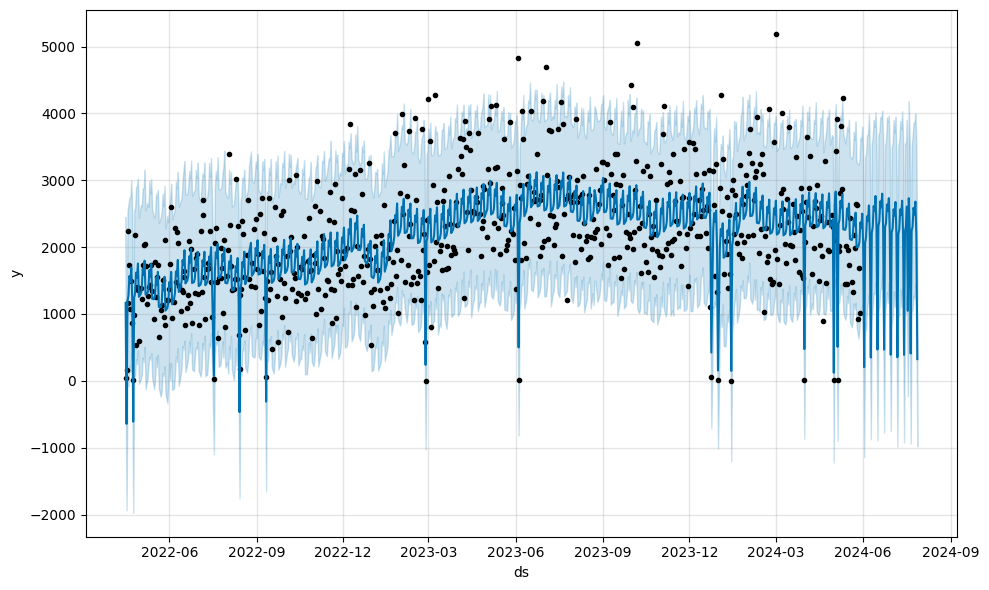

In [18]:
# Grafica las predicciones junto con el historial
fig1 = m.plot(forecast)

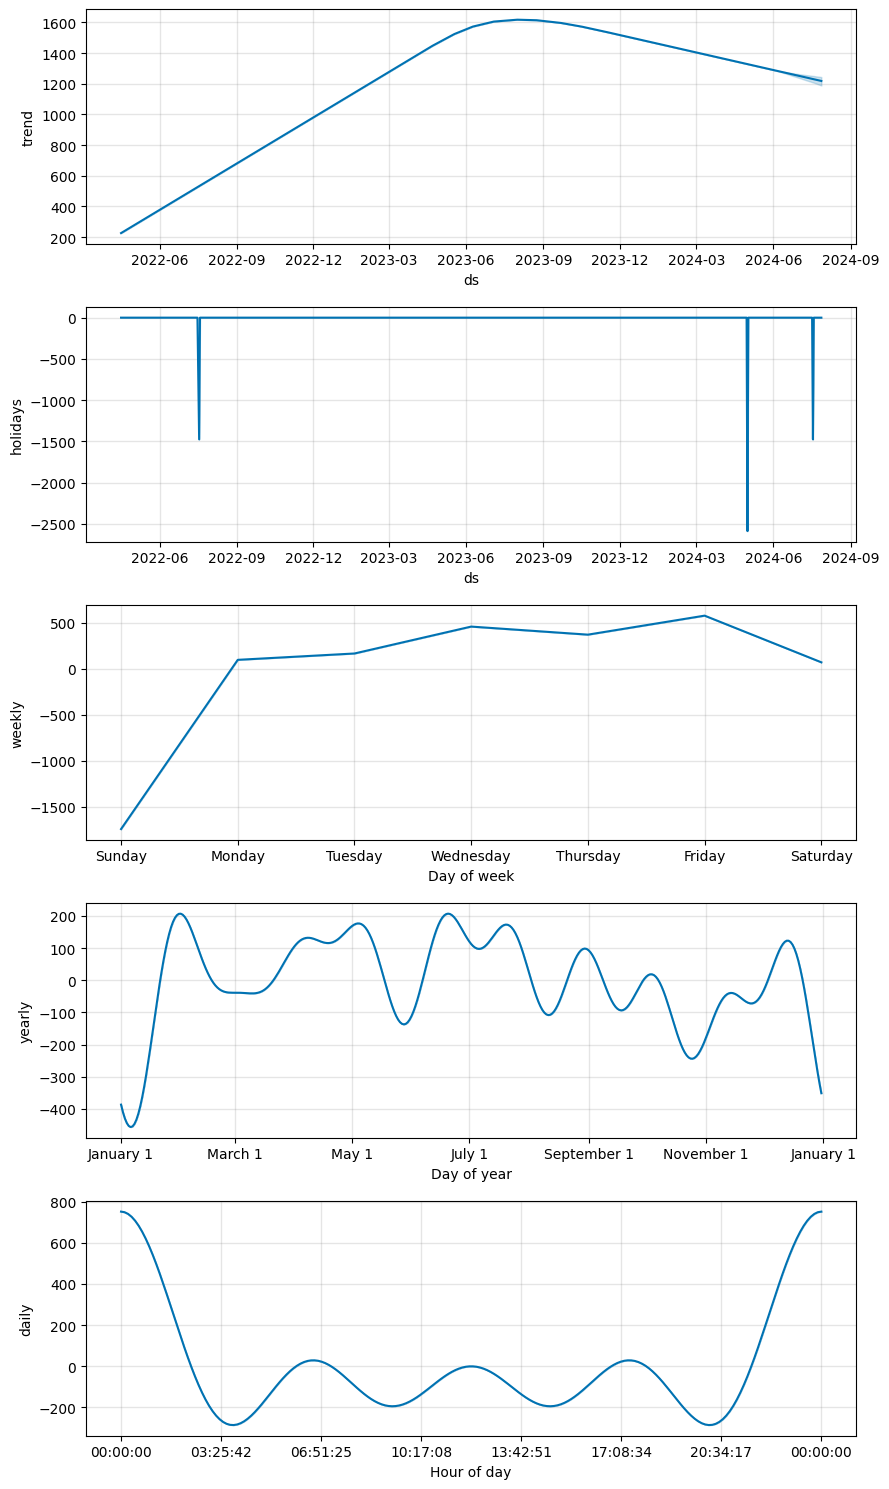

In [19]:
# Descompone y grafica los componentes de las predicciones (tendencia, estacionalidades, días festivos)
fig2 = m.plot_components(forecast)

In [20]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [22]:
plot_components_plotly(m, forecast)

#### Save model

In [23]:
from prophet.serialize import model_to_json, model_from_json

with open('prophet_model_completo_v1.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('prophet_model_completo_v1.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

#### Metrics - MSE and RMSE

,actual,predicted
664,2638.754,2514.803286
665,2632.372,1995.782061
666,918.313,2008.489136
667,1692.885,2075.356599
668,1017.785,2369.106392


Mean Squared Error (MSE): 440230.7517092283
Root Mean Squared Error (RMSE): 663.4988709178248


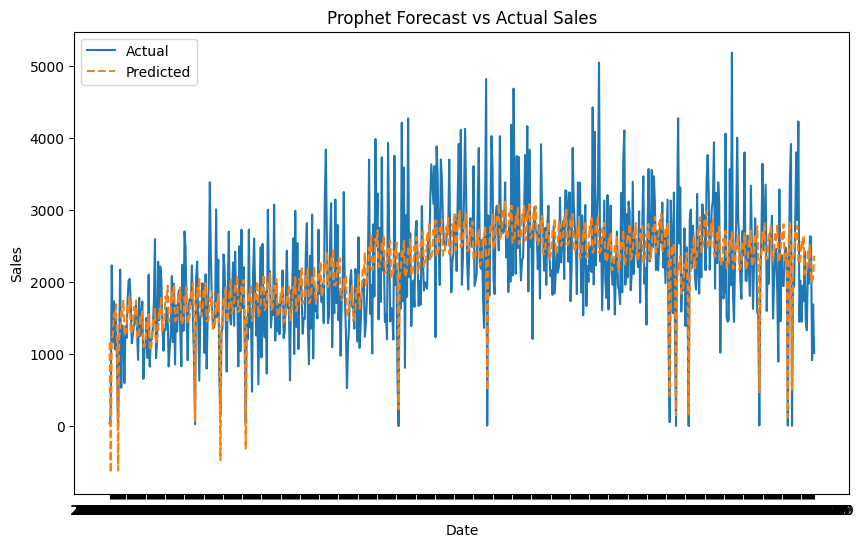

In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Extraer los valores reales y predichos para el cálculo del RMSE
y_true = df_prophet['y'].values  # Valores reales de ventas
y_pred = forecast['yhat'].iloc[:len(y_true)].values  # Predicciones del modelo Prophet

df_comparison = pd.DataFrame({
    'actual': y_true,
    'predicted': y_pred
})

# Si estás utilizando un entorno como Jupyter, puedes usar display para un mejor formato
from IPython.display import display
display(df_comparison.tail(5))

# Mostrar las métricas de error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Graficar las predicciones vs los valores reales (opcional)
plt.figure(figsize=(10, 6))
plt.plot(df_prophet['ds'], y_true, label='Actual')
plt.plot(df_prophet['ds'], y_pred, label='Predicted', linestyle='--')
plt.title('Prophet Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#### Backtesting

In [35]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(m, initial='365 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/1 [00:00<?, ?it/s]01:00:16 - cmdstanpy - INFO - Chain [1] start processing
01:00:16 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


In [36]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,35 days,8.803509e+05,938.270178,737.730305,4.807385,0.215461,0.306440,0.806452
1,36 days,8.717814e+05,933.692331,734.652751,4.802149,0.215461,0.303597,0.806452
2,37 days,8.137427e+05,902.076870,707.963709,4.772539,0.188897,0.287100,0.838710
3,38 days,8.246510e+05,908.102987,720.425187,4.778250,0.215461,0.291781,0.838710
4,39 days,6.674272e+05,816.962192,679.094768,4.772122,0.215461,0.281773,0.838710
...,...,...,...,...,...,...,...,...
280,360 days,4.960892e+06,2227.305903,2041.497422,28.229330,1.046494,0.714680,0.161290
281,361 days,4.734326e+06,2175.850740,1983.274778,28.139793,1.041097,0.685782,0.193548
282,363 days,5.031274e+06,2243.050093,2057.757630,28.242140,1.046494,0.719227,0.161290
283,364 days,4.986002e+06,2232.935728,2048.467503,28.228789,1.046494,0.715002,0.161290


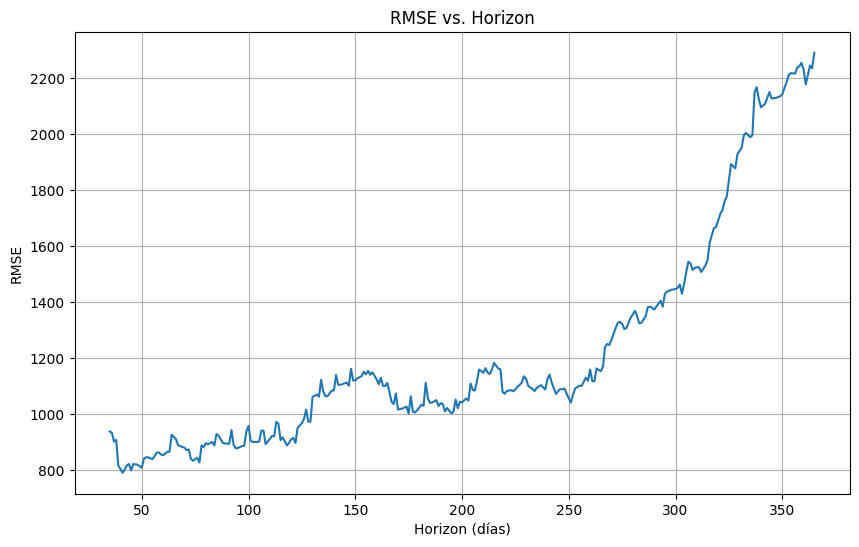

In [37]:
import matplotlib.pyplot as plt

# Asegurarte de que `horizon` esté en días (en caso de que esté en timedelta u otra unidad)
df_p['horizon'] = df_p['horizon'].dt.days  # Si 'horizon' está en formato timedelta

# Graficar el RMSE
plt.figure(figsize=(10, 6))
plt.plot(df_p['horizon'], df_p['rmse'])
plt.title('RMSE vs. Horizon')
plt.xlabel('Horizon (días)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()